# Configs

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string

pd.set_option('display.max_columns', None)

# Funtion

In [ ]:
def quantify_missing_data_by_group(data, feature_group):
    """
    Quantify missing data for a specific group of features.
    Args:
        data (pd.DataFrame): The input dataset.
        feature_group (list): A list of features to analyze.
    Returns:
        pd.DataFrame: A summary of missing values for the feature group.
    """
    missing_count = data[feature_group].isnull().sum()
    missing_percentage = (missing_count / len(data)) * 100

    summary = pd.DataFrame({
        'Feature': feature_group,
        'Missing Count': missing_count,
        'Missing Percentage': missing_percentage
    }).sort_values(by='Missing Percentage', ascending=False)

    # Plot missing percentages
    summary[summary['Missing Percentage'] > 0].set_index('Feature').plot(
        kind='bar',
        y='Missing Percentage',
        legend=False,
        title=f'Percentage of Missing Values by Feature in Group',
        figsize=(10, 6)
    )
    plt.ylabel('Percentage')
    plt.xlabel('Features')
    plt.tight_layout()
    plt.show()

    return summary

In [ ]:
def clean_float_column(df, column_name):
    """
    Cleans a float column in a Pandas DataFrame by:
    - Removing excess characters from numeric values.
    - Replacing values containing only characters with NaN.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        column_name (str): The name of the column to clean.

    Returns:
        pd.DataFrame: The DataFrame with the cleaned column.
    """
    def clean_value(value):
        try:
            # Try to extract a float from the value
            return float(''.join(ch for ch in str(value) if ch.isdigit() or ch == '.' or ch == '-'))
        except ValueError:
            # If conversion fails, return NaN
            return np.nan

    # Apply the cleaning function to the column
    df[column_name] = df[column_name].apply(clean_value)

    return df

In [ ]:
def convert_credit_history_to_float(df, column_name):
    """
    Converts a column with values like '(number) years and (number) months' into float values.
    Example: '29 years and 6 months' -> 29.5

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        column_name (str): The name of the column to convert.

    Returns:
        pd.DataFrame: The DataFrame with the converted column.
    """
    def parse_credit_history(value):
        try:
            # Extract years and months from the string
            parts = str(value).lower().replace('and', '').split()
            years = int(parts[0]) if 'year' in parts[1] else 0
            months = int(parts[2]) if len(parts) > 2 and 'month' in parts[3] else 0
            return years + months / 12.0
        except (IndexError, ValueError):
            return np.nan

    df[column_name] = df[column_name].apply(parse_credit_history)
    return df

In [ ]:
def plot_feature_distribution_by_target(data, features, target_column='Credit_Score', fill=True, alpha=0.3):
    num_features = len(features)

    if num_features == 0:
        print("No features provided for visualization.")
        return

    plt.figure(figsize=(12, 6 * ((num_features + 1) // 2)))

    for i, feature in enumerate(features):
        if feature not in data.columns:
            print(f"Feature '{feature}' not found in the dataset. Skipping...")
            continue

        plt.subplot((num_features + 1) // 2, 2, i + 1)
        sns.kdeplot(data.loc[data[target_column] == 0, feature], label=f'{target_column} == 0', color='blue')
        sns.kdeplot(data.loc[data[target_column] == 1, feature], label=f'{target_column} == 1', color='red')
        plt.title(f'Distribution of {feature} by {target_column}')
        plt.xlabel(feature)
        plt.ylabel('Density')
        plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
def plot_count_by_target_bar(df, columns, target):
    for col in columns:
        plt.figure(figsize=(10, 6))
        sns.countplot(data=df, x=col, hue=target)
        plt.xticks(rotation=45)
        plt.title(f'Count of {col} by {target}')
        plt.legend(title=target)
        plt.show()

# Import

In [ ]:
#train = pd.read_csv('train.csv')
df = pd.read_csv('/content/train.csv')

df["is_train"] = True

col_to_drop = ['Credit_Mix', 'SSN', 'ID', 'Month', 'Name'] # --> drop ['ID', 'Month', 'Name', 'SSN', 'Credit_Mix']
df.drop(columns=col_to_drop, inplace=True)



<ipython-input-133-e2a6208c03a4>:2: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/train.csv')


# Preprocessing

The dataset is focused on a **Credit Score classification problem**. The company has collected basic banking details along with extensive credit-related information. The management aims to develop an intelligent system to categorize individuals into credit score brackets, thereby minimizing manual effort.

Source: https://www.kaggle.com/datasets/parisrohan/credit-score-classification/data

The data includes
*   **Categorical information:** Occupation, Payment behaviour, Payment
*   **Numerical information:** Age, Annual income, Monthly inhand salary, Number of bank accounts, Number of credit card, Interest rate, Number of loan, Number of days delayed from due date payment, Number of delayed payment, Percentage change in credit card limit, Number of credit card inquiries, Outstanding Debt, Credit utilazation, Total EMI per month, Amount of monthly investment, Monthly balance
*   **Text information:** Type of Loan, Age of credit history

The **Credit Score** is classified into three, **'Good', 'Standard', and 'Poor'**. However, to simplify the results, **'Standard'** is merged into **'Good'**, turning into 2 classes.



In [ ]:
numeric_columns = df.select_dtypes(include=['number']).columns.tolist()

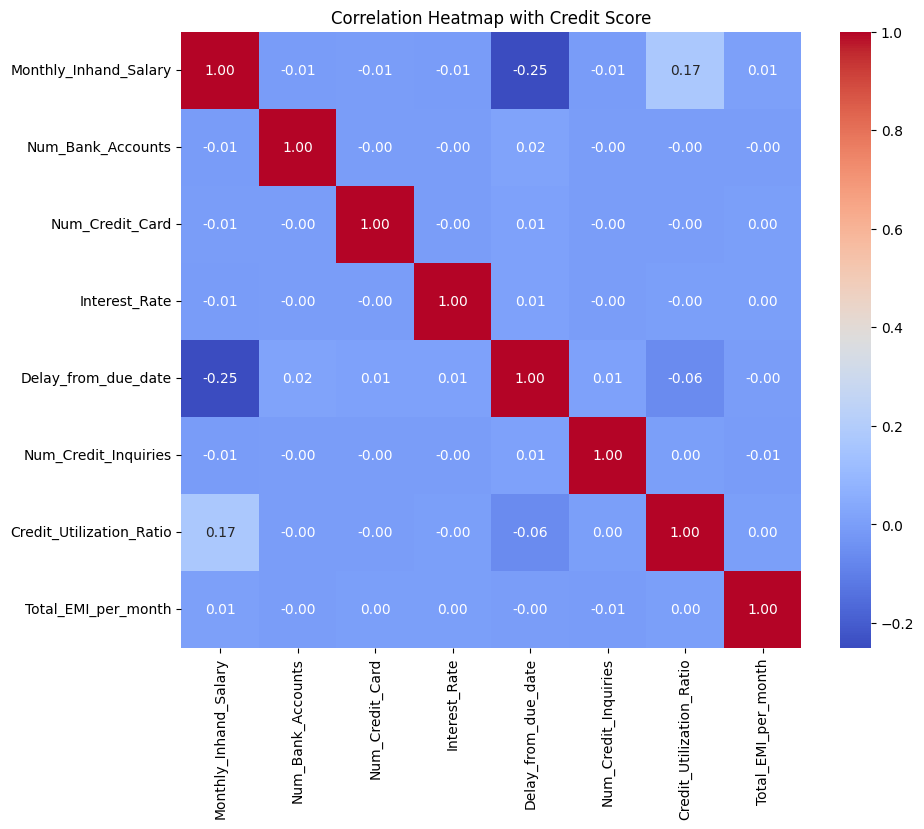

In [ ]:
numeric_df = df.select_dtypes(include="number")

plt.figure(figsize=(10, 8))

correlation_matrix = numeric_df.corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')

plt.title("Correlation Heatmap with Credit Score")
plt.show()

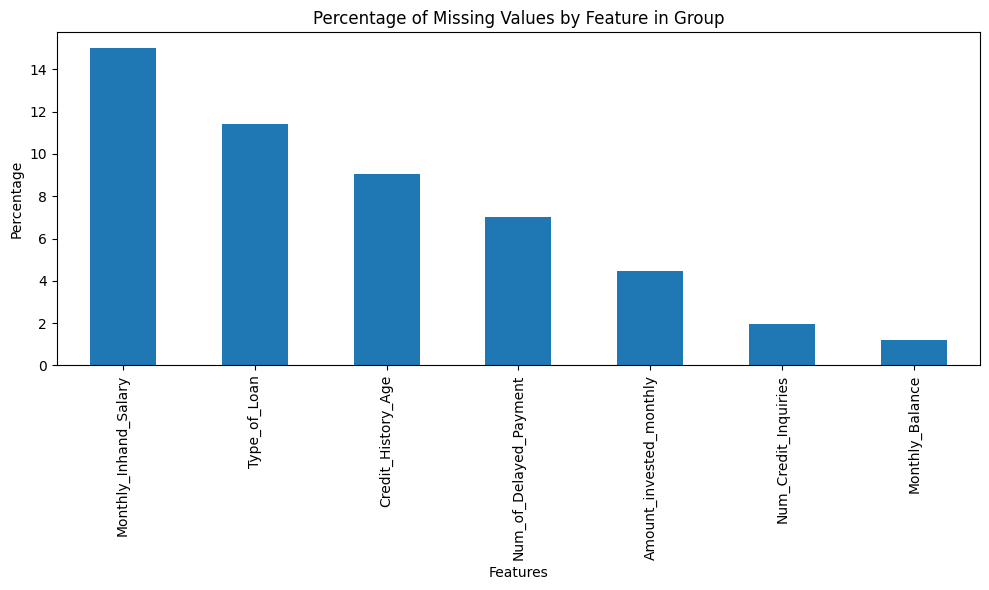

,Feature,Missing Count,Missing Percentage
Monthly_Inhand_Salary,Monthly_Inhand_Salary,15002,15.002
Type_of_Loan,Type_of_Loan,11408,11.408
Credit_History_Age,Credit_History_Age,9030,9.030
Num_of_Delayed_Payment,Num_of_Delayed_Payment,7002,7.002
Amount_invested_monthly,Amount_invested_monthly,4479,4.479
Num_Credit_Inquiries,Num_Credit_Inquiries,1965,1.965
Monthly_Balance,Monthly_Balance,1200,1.200
Interest_Rate,Interest_Rate,0,0.000
Num_of_Loan,Num_of_Loan,0,0.000
Num_Credit_Card,Num_Credit_Card,0,0.000


In [ ]:
cols = df.columns.drop(['Credit_Score', 'is_train'])
quantify_missing_data_by_group(df, cols)

In [ ]:
df['Credit_Score'] = df['Credit_Score'].map({'Good': 'Good', 'Standard': 'Good', 'Poor': 'Poor'})

<ipython-input-138-1ff9a9bbbe9d>:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({


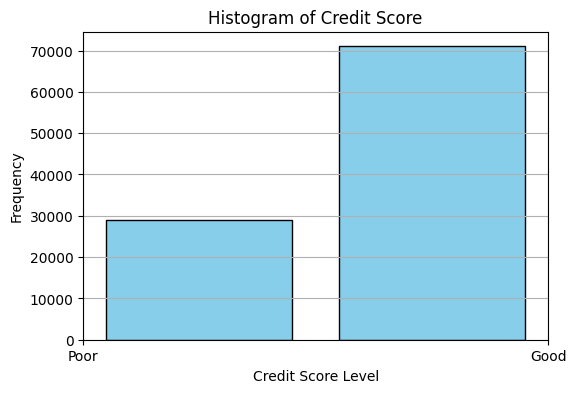

In [ ]:
# Map to Score level (0, 1)
df['Credit_Score'] = (
    df['Credit_Score']
    .replace({
        'Poor': 0,
        'Good': 1
    })
)

# Show histogram
plt.figure(figsize=(6, 4))
plt.title('Histogram of Credit Score')
plt.xlabel('Credit Score Level')
plt.ylabel('Frequency')
df['Credit_Score'].hist(bins=2, color='skyblue', edgecolor='black', rwidth=0.8)
plt.xticks([0, 1], ['Poor', 'Good'])
plt.show()


In [ ]:
df['Credit_Score'].value_counts()

,count
Credit_Score,
1,71002
0,28998


### Standardize # --> Data cleaning

In [ ]:
df[df['Occupation'] == '_______']
df['Occupation'] = df['Occupation'].replace('_______', np.nan)

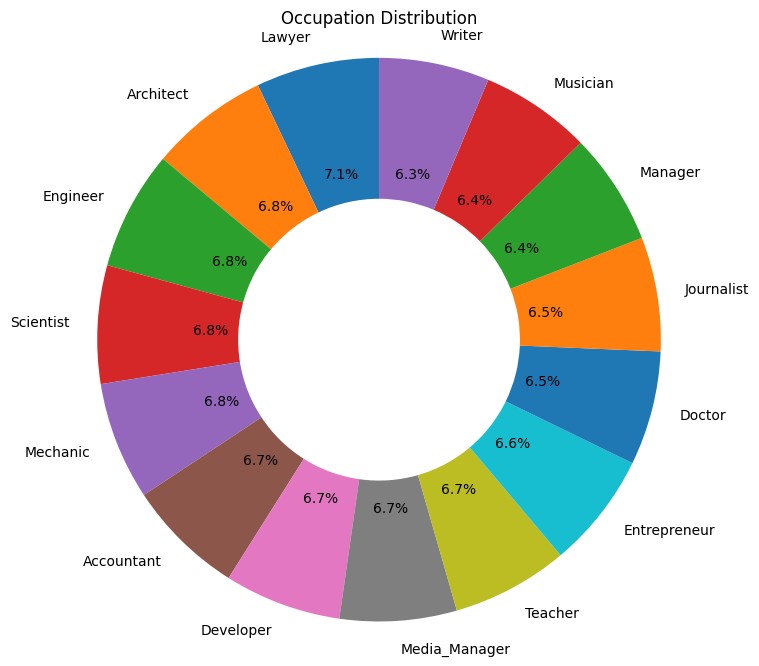

In [ ]:
plt.figure(figsize=(8, 8))
plt.pie(df["Occupation"].value_counts(),
        labels=df["Occupation"].value_counts().index,
        autopct='%1.1f%%',
        startangle=90,
        wedgeprops=dict(width=0.5))
plt.title("Occupation Distribution")
plt.axis('equal')
plt.show()

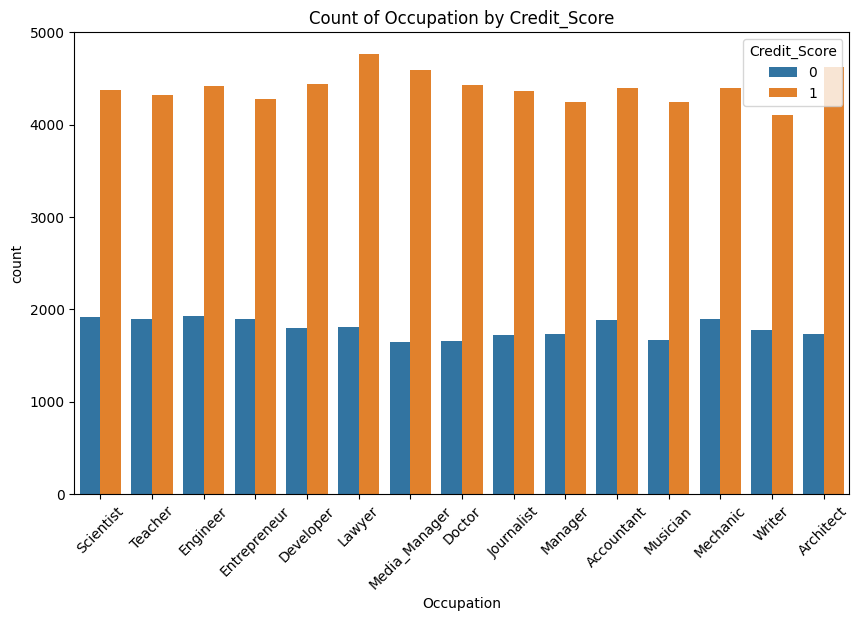

In [ ]:
plot_count_by_target_bar(df, ['Occupation'], 'Credit_Score')

In [ ]:
wrong_cols = ['Changed_Credit_Limit', 'Outstanding_Debt', 'Amount_invested_monthly',
        'Age', 'Num_of_Loan', 'Num_of_Delayed_Payment', 'Annual_Income']
for col in wrong_cols:
  clean_float_column(df, col)

<ipython-input-144-7eb2cfbb222f>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, y="Age", palette="Set3")


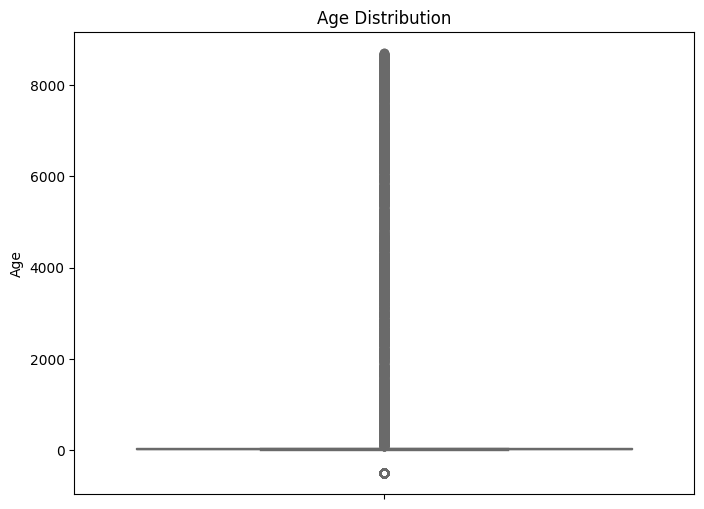

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, y="Age", palette="Set3")
plt.title("Age Distribution")
plt.show()

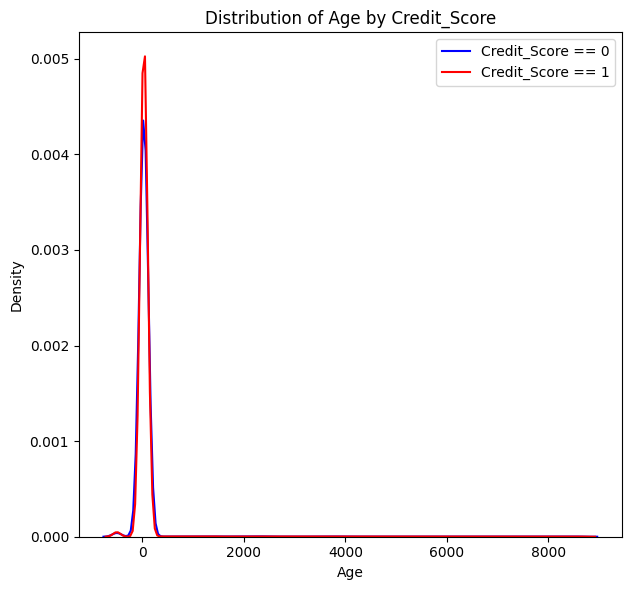

In [ ]:
plot_feature_distribution_by_target(df, ['Age'], target_column='Credit_Score', fill=True, alpha=0.3)

<Axes: title={'center': 'Histogram of Age'}, xlabel='Age', ylabel='Frequency'>

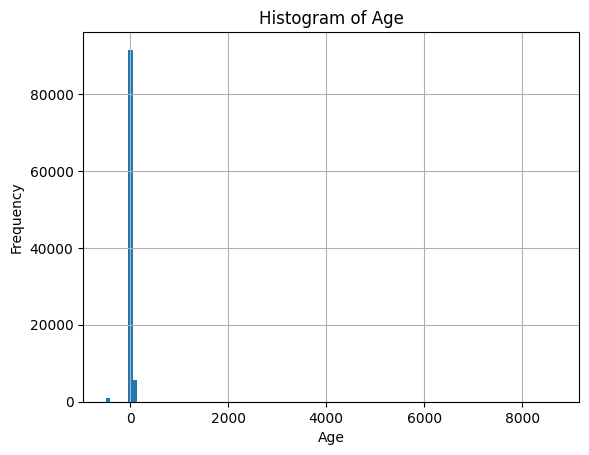

In [ ]:
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
(
    df['Age']
    .replace('_', '', regex=True)
    .astype('int')
    .hist(bins=100)
)

In [ ]:
df['Num_Bank_Accounts'] = df['Num_Bank_Accounts'].apply(lambda x: np.nan if x < 0 else x)

<ipython-input-148-a3793d1c2dd1>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, y="Num_Bank_Accounts", palette="Set3")


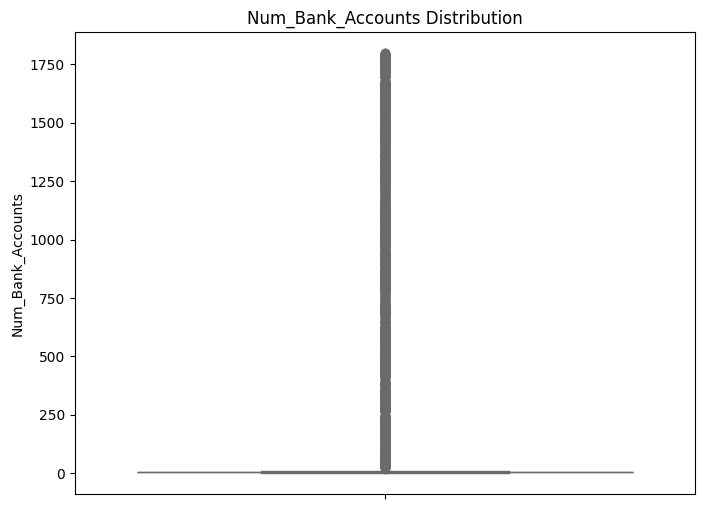

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, y="Num_Bank_Accounts", palette="Set3")
plt.title("Num_Bank_Accounts Distribution")
plt.show()

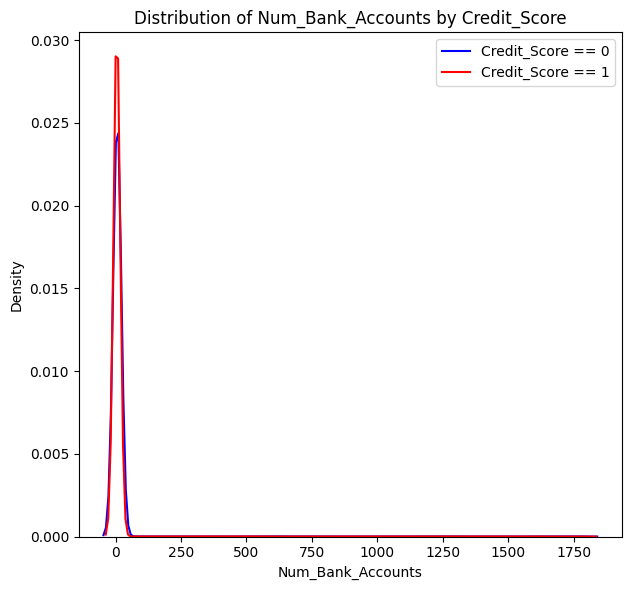

In [ ]:
plot_feature_distribution_by_target(df, ['Num_Bank_Accounts'], target_column='Credit_Score', fill=True, alpha=0.3)

In [ ]:
df['Num_of_Delayed_Payment'] = df['Num_of_Delayed_Payment'].apply(lambda x: np.nan if x < 0 else x)

<ipython-input-151-5cfcf0fe8e6f>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, y="Num_of_Delayed_Payment", palette="Set3")


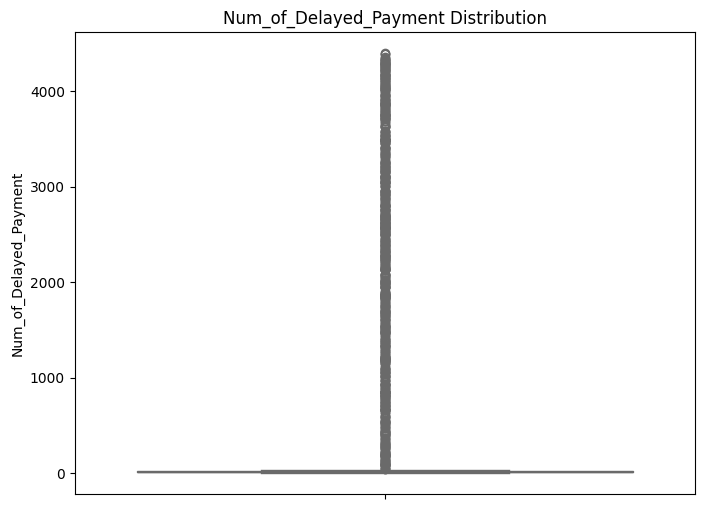

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, y="Num_of_Delayed_Payment", palette="Set3")
plt.title("Num_of_Delayed_Payment Distribution")
plt.show()

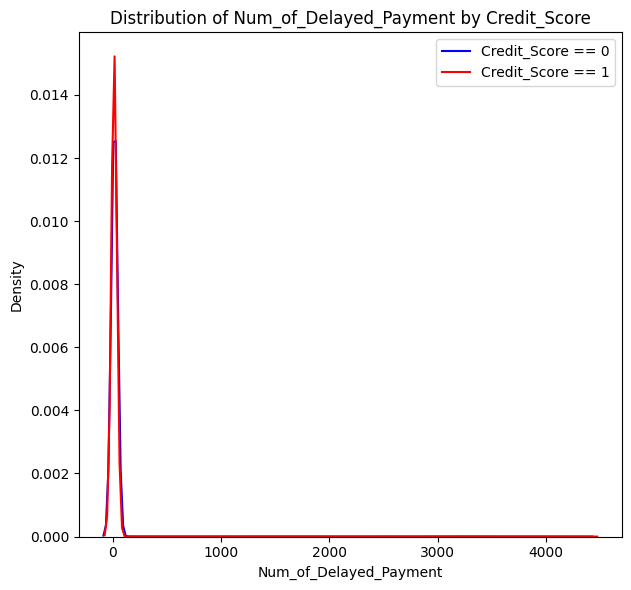

In [ ]:
plot_feature_distribution_by_target(df, ['Num_of_Delayed_Payment'], target_column='Credit_Score', fill=True, alpha=0.3)

In [ ]:
df['Num_of_Loan'].astype(float)
df['Num_of_Loan'] = df['Num_of_Loan'].apply(lambda x: np.nan if x < 0 else x)

<ipython-input-154-5bf0f4419adc>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, y="Num_of_Loan", palette="Set3")


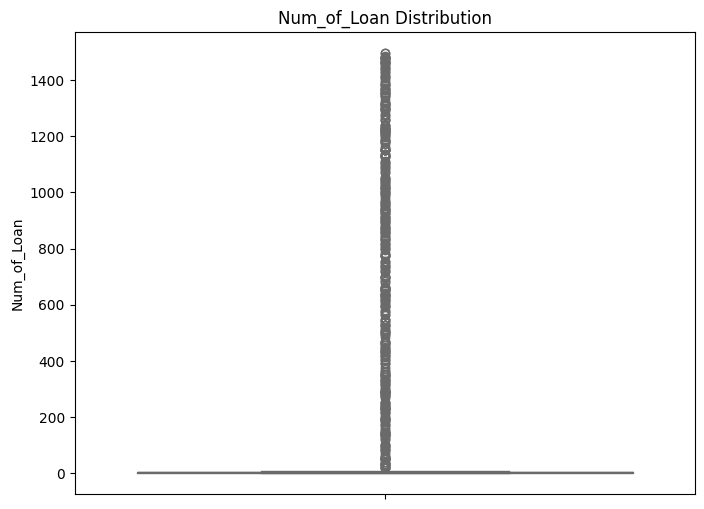

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, y="Num_of_Loan", palette="Set3")
plt.title("Num_of_Loan Distribution")
plt.show()

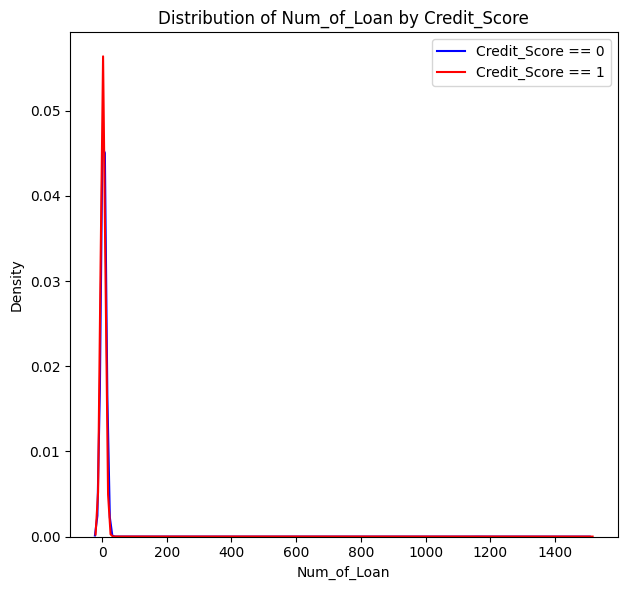

In [ ]:
plot_feature_distribution_by_target(df, ['Num_of_Loan'], target_column='Credit_Score', fill=True, alpha=0.3)

In [ ]:
df['Payment_Behaviour'] = df['Payment_Behaviour'].apply(lambda x: x.replace('_', ' ') if isinstance(x, str) else x)
df['Payment_Behaviour'] = df['Payment_Behaviour'].replace('!@9#%8', np.nan)

<ipython-input-157-bebc42deb424>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, y="Payment_Behaviour", palette="Set3")


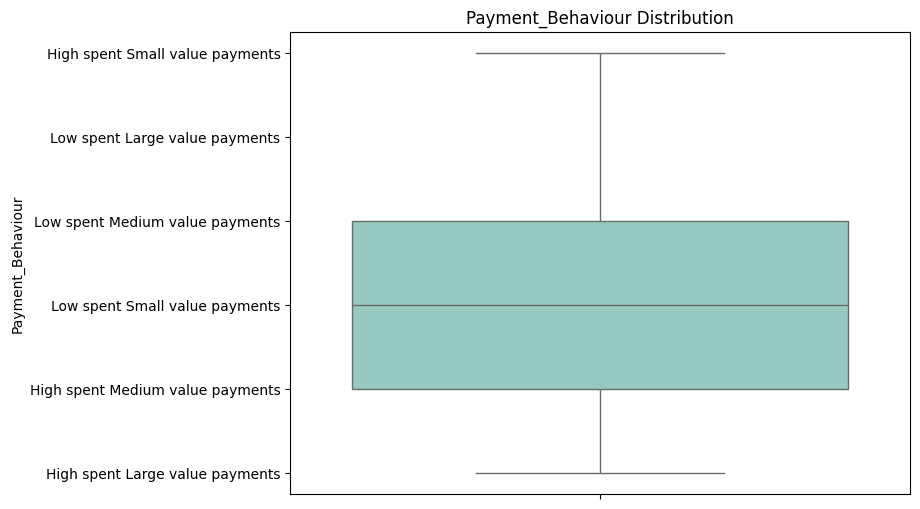

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, y="Payment_Behaviour", palette="Set3")
plt.title("Payment_Behaviour Distribution")
plt.show()

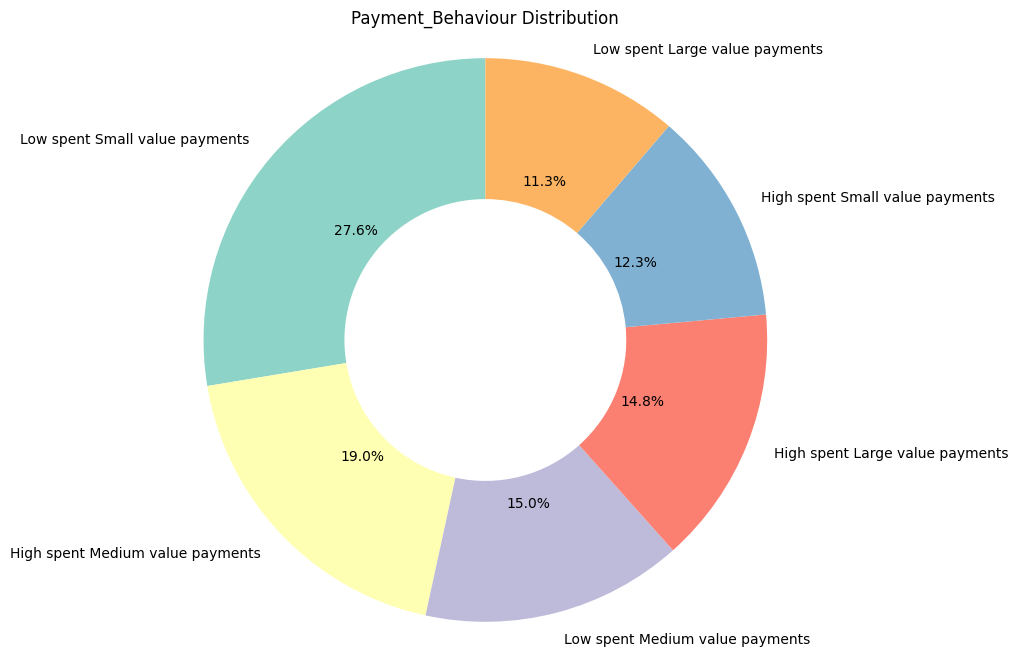

In [ ]:
plt.figure(figsize=(8, 8))
plt.pie(df["Payment_Behaviour"].value_counts(),
        labels=df["Payment_Behaviour"].value_counts().index,
        autopct='%1.1f%%',
        startangle=90,
        colors=plt.cm.Set3.colors,
        wedgeprops=dict(width=0.5))
plt.title("Payment_Behaviour Distribution")
plt.axis('equal')
plt.show()

In [ ]:
df['Monthly_Balance'] = df['Monthly_Balance'].replace('__-333333333333333333333333333__', np.nan)


### Transform

**Object to Float:** Features that previously contained unnecessary characters are stored as Object type. We convert these features back to Float after cleaning.

**'Credit_History_Age':** Values in this feature is in '(number) years and (number) months' format, we convert this into Float

<ipython-input-160-b332ff604eed>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, y="Annual_Income", palette="Set3")


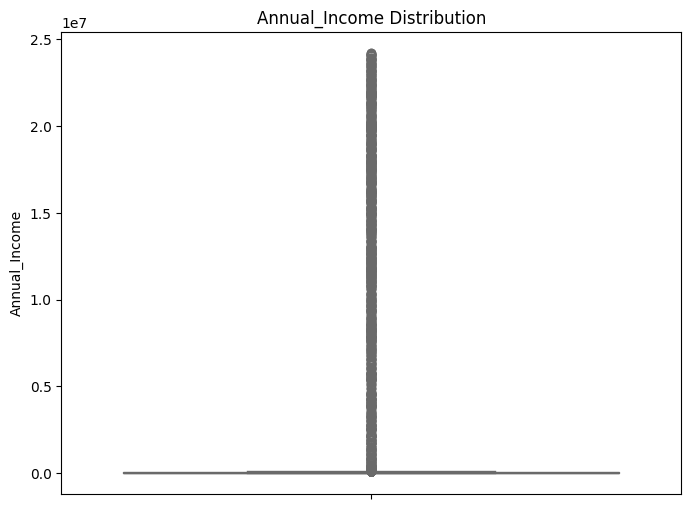

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, y="Annual_Income", palette="Set3")
plt.title("Annual_Income Distribution")
plt.show()

<Axes: title={'center': 'Histogram of Annual_Income by Monthly_Inhand_Salary'}, xlabel='Annual_Income by Monthly_Inhand_Salary', ylabel='Frequency'>

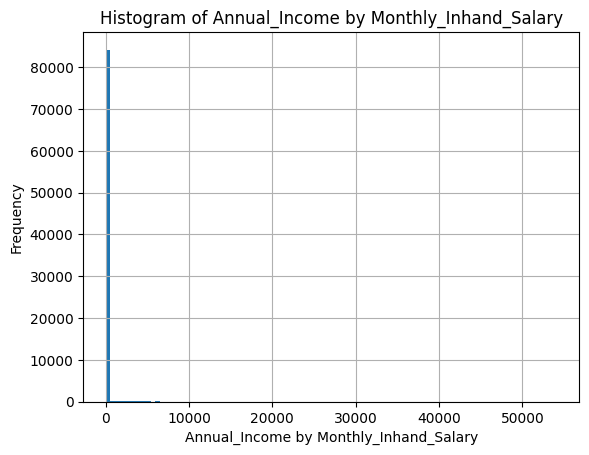

In [ ]:
plt.title('Histogram of Annual_Income by Monthly_Inhand_Salary')
plt.xlabel('Annual_Income by Monthly_Inhand_Salary')
plt.ylabel('Frequency')
(
    (df['Annual_Income']/df['Monthly_Inhand_Salary'])
    .hist(bins=100)
)

In [ ]:
to_float = ['Changed_Credit_Limit', 'Outstanding_Debt', 'Amount_invested_monthly',
            'Age', 'Num_of_Loan', 'Num_of_Delayed_Payment', 'Monthly_Balance', 'Annual_Income']
for col in to_float:
    df[col] = pd.to_numeric(df[col], errors='coerce', downcast='float')

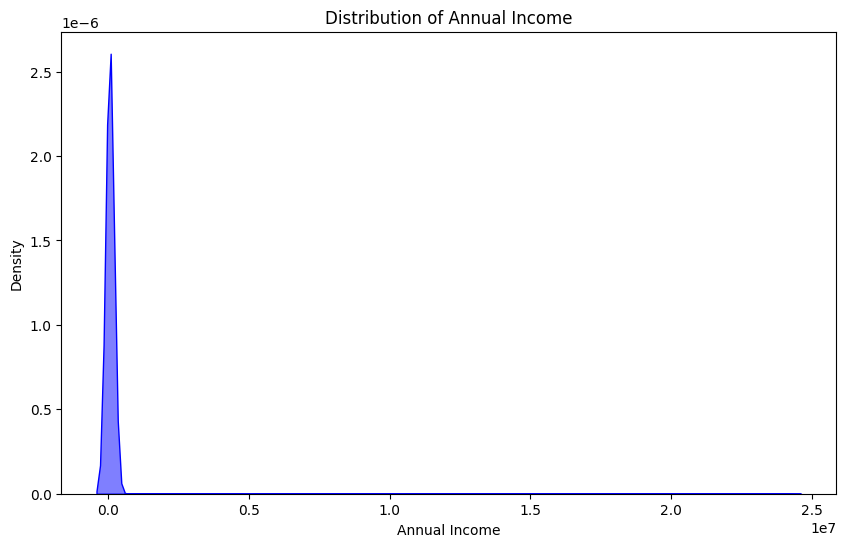

In [ ]:
plt.figure(figsize=(10, 6))

sns.kdeplot(data=df['Annual_Income'], color='blue', fill=True, alpha=0.5)

# Customize the plot
plt.title("Distribution of Annual Income")
plt.xlabel("Annual Income")
plt.ylabel("Density")
plt.show()

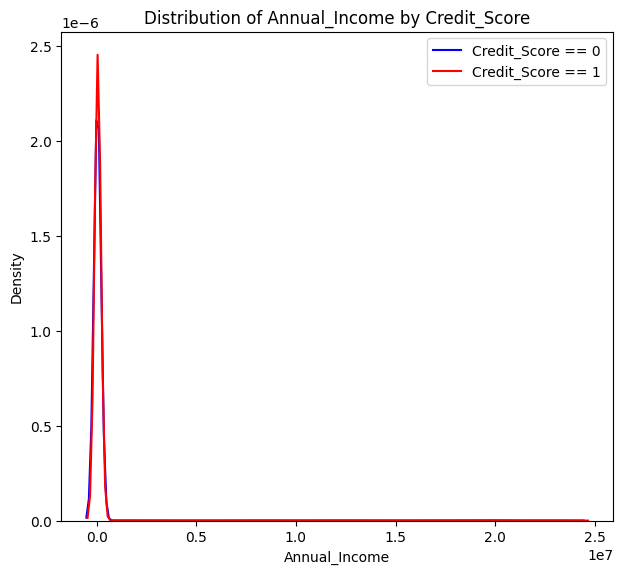

In [ ]:
plot_feature_distribution_by_target(df, ['Annual_Income'], target_column='Credit_Score', fill=True, alpha=0.3)

<Axes: title={'center': 'Histogram of Credit_Utilization_Ratio'}, xlabel='Credit_Utilization_Ratio', ylabel='Frequency'>

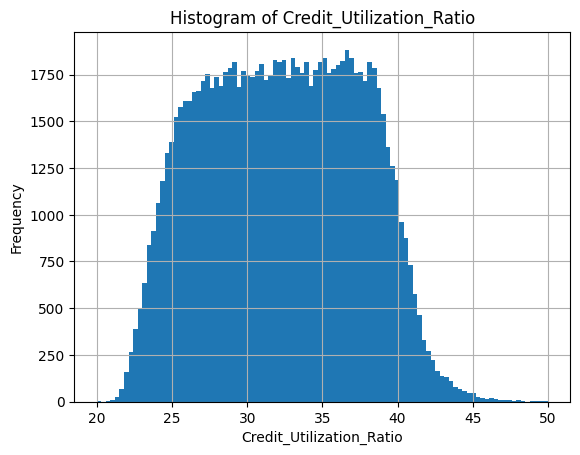

In [ ]:
plt.title('Histogram of Credit_Utilization_Ratio')
plt.xlabel('Credit_Utilization_Ratio')
plt.ylabel('Frequency')
df['Credit_Utilization_Ratio'].hist(bins=100)

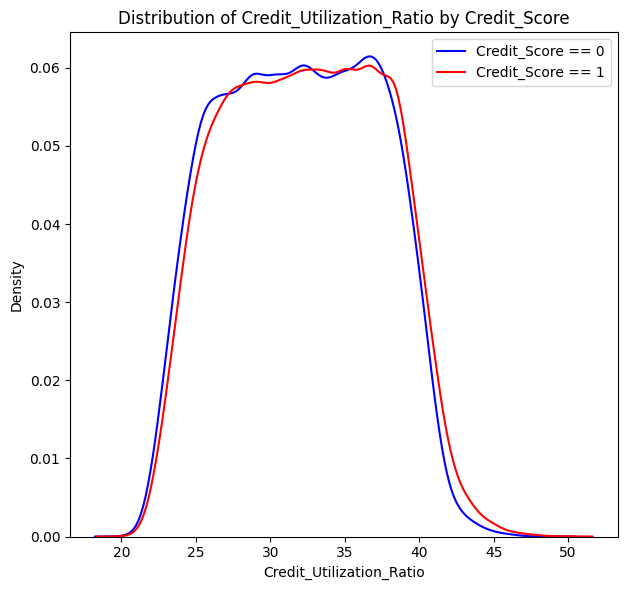

In [ ]:
plot_feature_distribution_by_target(df, ['Credit_Utilization_Ratio'], target_column='Credit_Score', fill=True, alpha=0.3)

In [ ]:
convert_credit_history_to_float(df, 'Credit_History_Age')

,Customer_ID,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,is_train
0,CUS_0xd40,23.0,Scientist,19114.12,1824.843333,3.0,4,3,4.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7.0,11.27,4.0,809.979980,26.822620,22.083333,No,49.574949,80.415298,High spent Small value payments,312.494080,1,True
1,CUS_0xd40,23.0,Scientist,19114.12,NaN,3.0,4,3,4.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",-1,NaN,11.27,4.0,809.979980,31.944960,NaN,No,49.574949,118.280220,Low spent Large value payments,284.629150,1,True
2,CUS_0xd40,-500.0,Scientist,19114.12,NaN,3.0,4,3,4.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7.0,NaN,4.0,809.979980,28.609352,22.250000,No,49.574949,81.699524,Low spent Medium value payments,331.209869,1,True
3,CUS_0xd40,23.0,Scientist,19114.12,NaN,3.0,4,3,4.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",5,4.0,6.27,4.0,809.979980,31.377862,22.333333,No,49.574949,199.458069,Low spent Small value payments,223.451309,1,True
4,CUS_0xd40,23.0,Scientist,19114.12,1824.843333,3.0,4,3,4.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",6,NaN,11.27,4.0,809.979980,24.797347,22.416667,No,49.574949,41.420155,High spent Medium value payments,341.489227,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,CUS_0x942c,25.0,Mechanic,39628.99,3359.415833,4.0,6,7,2.0,"Auto Loan, and Student Loan",23,7.0,11.50,3.0,502.380005,34.663572,31.500000,No,35.104023,60.971333,High spent Large value payments,479.866241,0,True
99996,CUS_0x942c,25.0,Mechanic,39628.99,3359.415833,4.0,6,7,2.0,"Auto Loan, and Student Loan",18,7.0,11.50,3.0,502.380005,40.565631,31.583333,No,35.104023,54.185951,High spent Medium value payments,496.651611,0,True
99997,CUS_0x942c,25.0,Mechanic,39628.99,3359.415833,4.0,6,5729,2.0,"Auto Loan, and Student Loan",27,6.0,11.50,3.0,502.380005,41.255522,31.666667,No,35.104023,24.028477,High spent Large value payments,516.809082,0,True
99998,CUS_0x942c,25.0,Mechanic,39628.99,3359.415833,4.0,6,7,2.0,"Auto Loan, and Student Loan",20,NaN,11.50,3.0,502.380005,33.638208,31.750000,No,35.104023,251.672577,Low spent Large value payments,319.164978,1,True


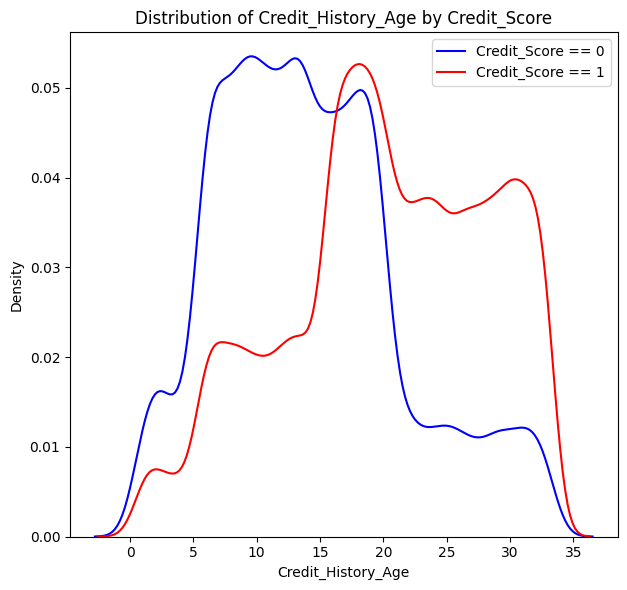

In [ ]:
plot_feature_distribution_by_target(df, ['Credit_History_Age'], target_column='Credit_Score', fill=True, alpha=0.3)

### Fill NaN

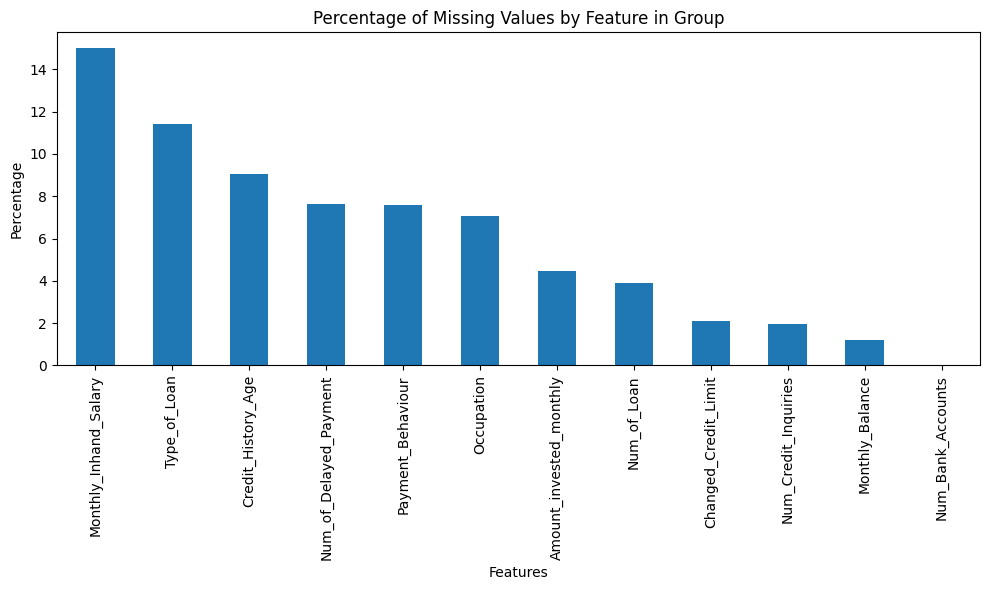

,Feature,Missing Count,Missing Percentage
Monthly_Inhand_Salary,Monthly_Inhand_Salary,15002,15.002
Type_of_Loan,Type_of_Loan,11408,11.408
Credit_History_Age,Credit_History_Age,9030,9.030
Num_of_Delayed_Payment,Num_of_Delayed_Payment,7646,7.646
Payment_Behaviour,Payment_Behaviour,7600,7.600
Occupation,Occupation,7062,7.062
Amount_invested_monthly,Amount_invested_monthly,4479,4.479
Num_of_Loan,Num_of_Loan,3876,3.876
Changed_Credit_Limit,Changed_Credit_Limit,2091,2.091
Num_Credit_Inquiries,Num_Credit_Inquiries,1965,1.965


In [ ]:
quantify_missing_data_by_group(df, df.columns)

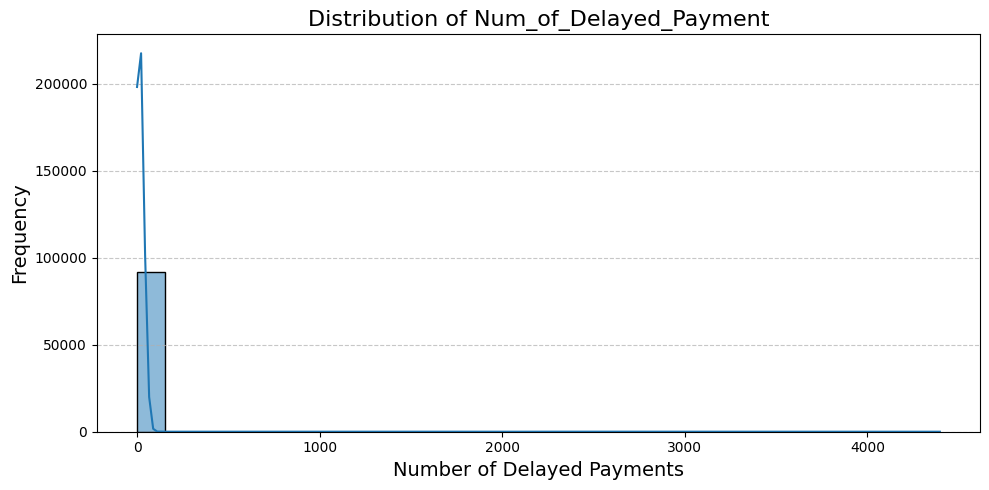

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x="Num_of_Delayed_Payment", bins=29, kde=True)

plt.title('Distribution of Num_of_Delayed_Payment', fontsize=16)
plt.xlabel('Number of Delayed Payments', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

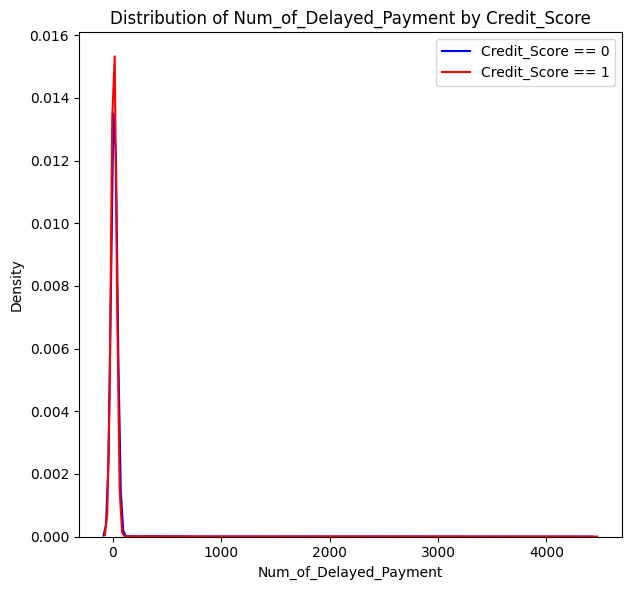

In [ ]:
plot_feature_distribution_by_target(df, ['Num_of_Delayed_Payment'], target_column='Credit_Score', fill=True, alpha=0.3)

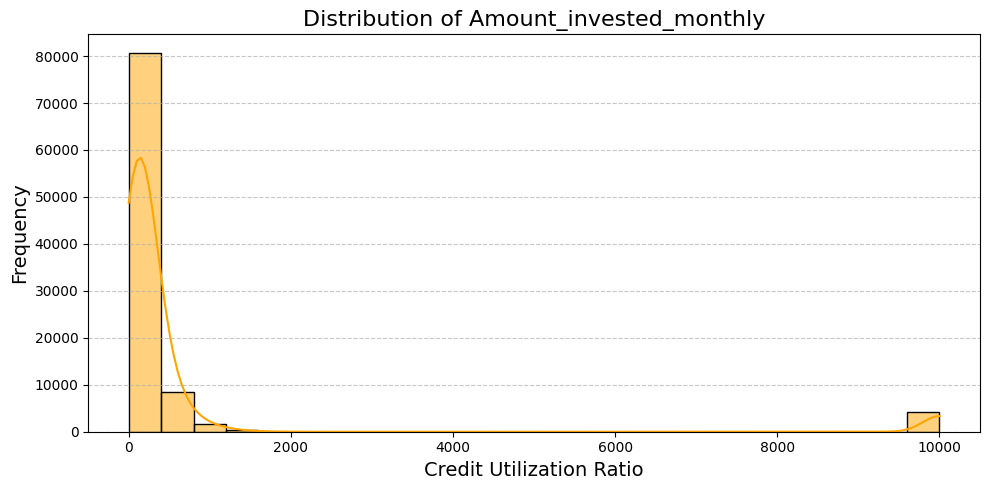

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x="Amount_invested_monthly", bins=25, kde=True, color='orange')

plt.title('Distribution of Amount_invested_monthly', fontsize=16)
plt.xlabel('Amount_invested_monthly', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

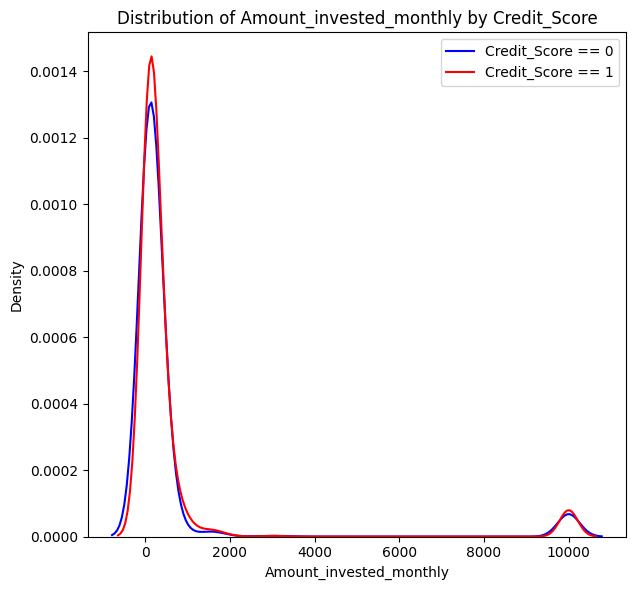

In [ ]:
plot_feature_distribution_by_target(df, ['Amount_invested_monthly'], target_column='Credit_Score', fill=True, alpha=0.3)

In [ ]:
miss_num_cols = ['Monthly_Inhand_Salary', 'Num_of_Delayed_Payment',
            'Amount_invested_monthly', 'Changed_Credit_Limit',
            'Num_Credit_Inquiries', 'Monthly_Balance', 'Num_Bank_Accounts', 'Num_of_Loan']
for col in miss_num_cols:
  df[col] = df.groupby('Customer_ID')[col].transform(
      lambda x:x.fillna(x.mean())
  )

miss_cat_cols = ['Occupation', 'Payment_Behaviour']
for col in miss_cat_cols:
  df[col] = df.groupby('Customer_ID')[col].transform(
      lambda x:x.fillna(x.mode()[0])
  )

#### Type of Loan

In [ ]:
df[df['Num_of_Loan'] == 0]['Customer_ID'].count()

11332

In [ ]:
df.loc[df['Num_of_Loan'] == 0, 'Type_of_Loan'] = 'No Loan'

In [ ]:
df['Type_of_Loan'] = df.groupby('Customer_ID')['Type_of_Loan'].transform(
    lambda x: x.fillna('Not Specified')
)

#### Credit_History_Age

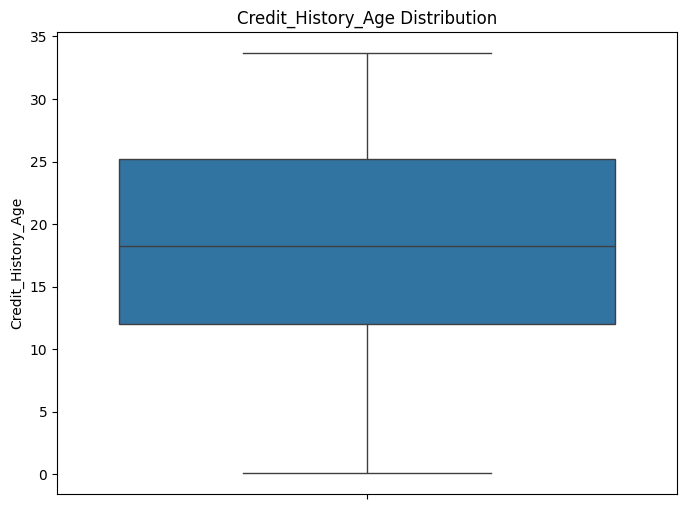

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, y="Credit_History_Age")
plt.title("Credit_History_Age Distribution")
plt.show()

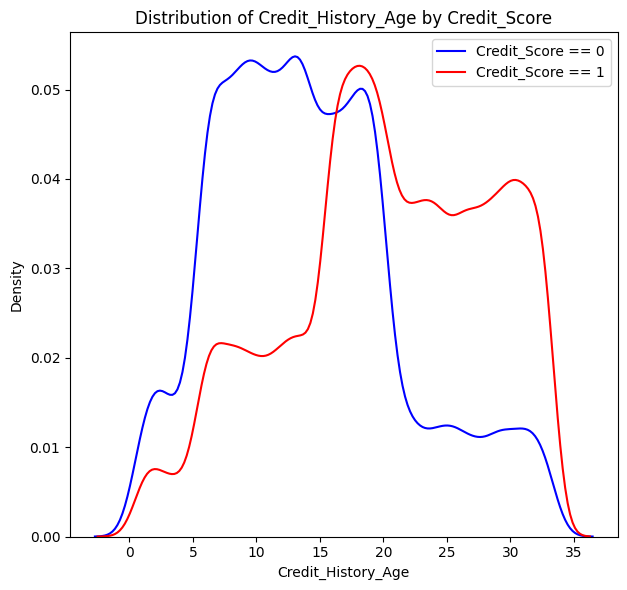

In [ ]:
plot_feature_distribution_by_target(df, ['Credit_History_Age'], target_column='Credit_Score', fill=True, alpha=0.3)

<Axes: title={'center': 'Histogram of Outstanding_Debt by Credit_History_Age'}, xlabel='Outstanding_Debt by Credit_History_Age', ylabel='Frequency'>

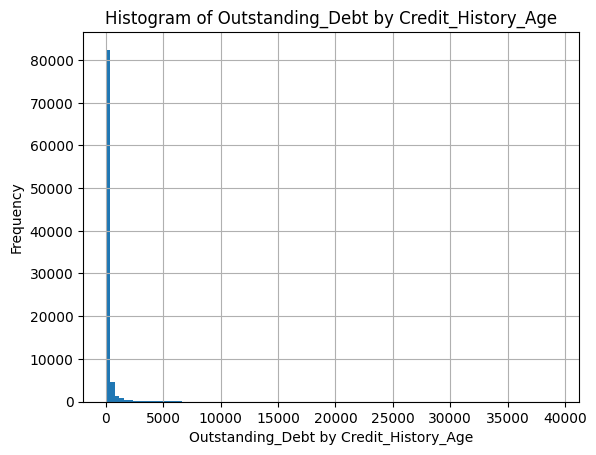

In [ ]:
# Show histogram of Credit_History_Age by Outstanding_Debt
plt.title('Histogram of Outstanding_Debt by Credit_History_Age')
plt.xlabel('Outstanding_Debt by Credit_History_Age')
plt.ylabel('Frequency')
(
    (df['Outstanding_Debt'] / df['Credit_History_Age'])
    .hist(bins=100)
)


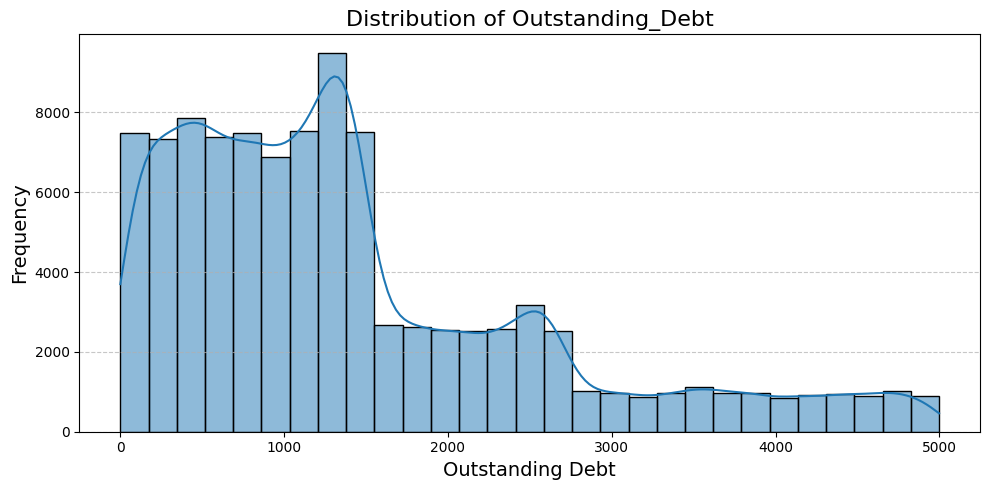

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x="Outstanding_Debt", bins=29, kde=True)

plt.title('Distribution of Outstanding_Debt', fontsize=16)
plt.xlabel('Outstanding Debt', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

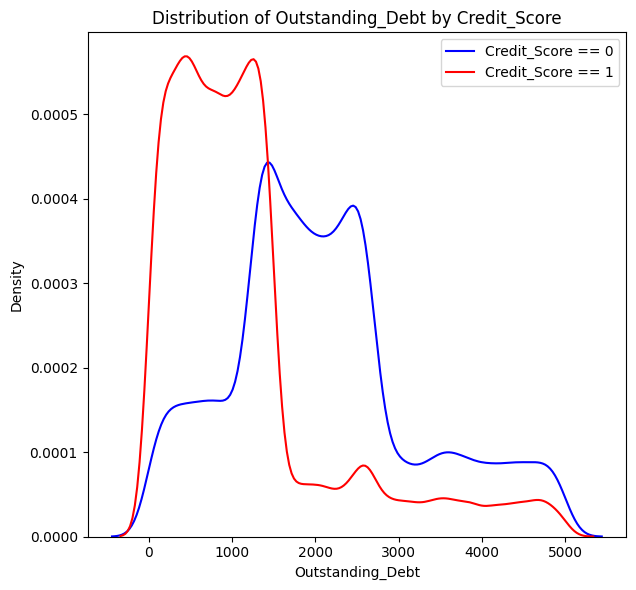

In [ ]:
plot_feature_distribution_by_target(df, ['Outstanding_Debt'], target_column='Credit_Score', fill=True, alpha=0.3)

In [ ]:
df['Credit_History_Age'] = pd.to_numeric(df['Credit_History_Age'], errors='coerce')

# Function to fill Credit_History_Age by increasing month by 1/12
def fill_credit_age(group):
    for _ in range(4):  # Iterate multiple times to ensure all gaps are filled
        for i in range(len(group)):
            if pd.isna(group['Credit_History_Age'].iloc[i]):
                # Case where there is a previous value (fill forward)
                if i > 0 and not pd.isna(group['Credit_History_Age'].iloc[i - 1]):
                    previous_age = group['Credit_History_Age'].iloc[i - 1]
                    group['Credit_History_Age'].iloc[i] = previous_age + 1 / 12
                elif i == 0 or pd.isna(group['Credit_History_Age'].iloc[i - 1]):
                    # Look ahead to the next available value and calculate backwards
                    if i + 1 < len(group) and not pd.isna(group['Credit_History_Age'].iloc[i + 1]):
                        next_age = group['Credit_History_Age'].iloc[i + 1]
                        group['Credit_History_Age'].iloc[i] = next_age - 1 / 12
    return group

# Apply the function for each Customer_ID
df = df.groupby('Customer_ID').apply(fill_credit_age)


Streaming output truncated to the last 5000 lines.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  group['Credit_History_Age'].iloc[i] = previous_age + 1 / 12
<ipython-input-180-f2b7db1b8174>:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://

### Handling Outliers

In [ ]:
# CHECK OUTLIERS
def find_outlier_columns(data, method):
    outlier_columns = []

    # Loop through numerical columns
    for column in data.select_dtypes(include='number').columns:
        if method == 'iqr':
            # Using the Interquartile Range (IQR) method to detect outliers
            Q1 = data[column].quantile(0.25)  # First quartile (25th percentile)
            Q3 = data[column].quantile(0.75)  # Third quartile (75th percentile)
            IQR = Q3 - Q1  # Interquartile range
            lower_limit = Q1 - 1.5 * IQR
            upper_limit = Q3 + 1.5 * IQR
            # Check if any values fall outside the bounds
            if ((data[column] < lower_limit) | (data[column] > upper_limit)).any():
                outlier_columns.append(column)
        elif method == 'std':
            # Using the Standard Deviation (STD) method to detect outliers
            mean_value = data[column].mean()
            std_dev = data[column].std()
            lower_limit = mean_value - 3 * std_dev
            upper_limit = mean_value + 3 * std_dev
            # Check if any values fall outside the bounds
            if ((data[column] < lower_limit) | (data[column] > upper_limit)).any():
                outlier_columns.append(column)

    return outlier_columns

# Function to create boxplots for columns with outliers
def visualize_outlier_columns(data, method='iqr'):
    outlier_columns = find_outlier_columns(data, method)

    # If no outliers are found, exit the function
    if not outlier_columns:
        print("No outliers detected in any column.")
        return

    # Calculate layout for boxplots
    total_columns = len(outlier_columns)
    rows = (total_columns + 2) // 3  # Arrange plots in rows with 3 plots per row

    # Create subplots
    fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))
    axes = axes.flatten()

    # Generate a boxplot for each column with outliers
    for idx, column in enumerate(outlier_columns):
        sns.boxplot(x=data[column], ax=axes[idx])
        axes[idx].set_title(f'Boxplot: {column}')
        axes[idx].set_xlabel('Values')

    # Turn off unused axes
    for idx in range(total_columns, len(axes)):
        axes[idx].axis('off')

    # Adjust layout and display the plots
    plt.tight_layout()
    plt.show()

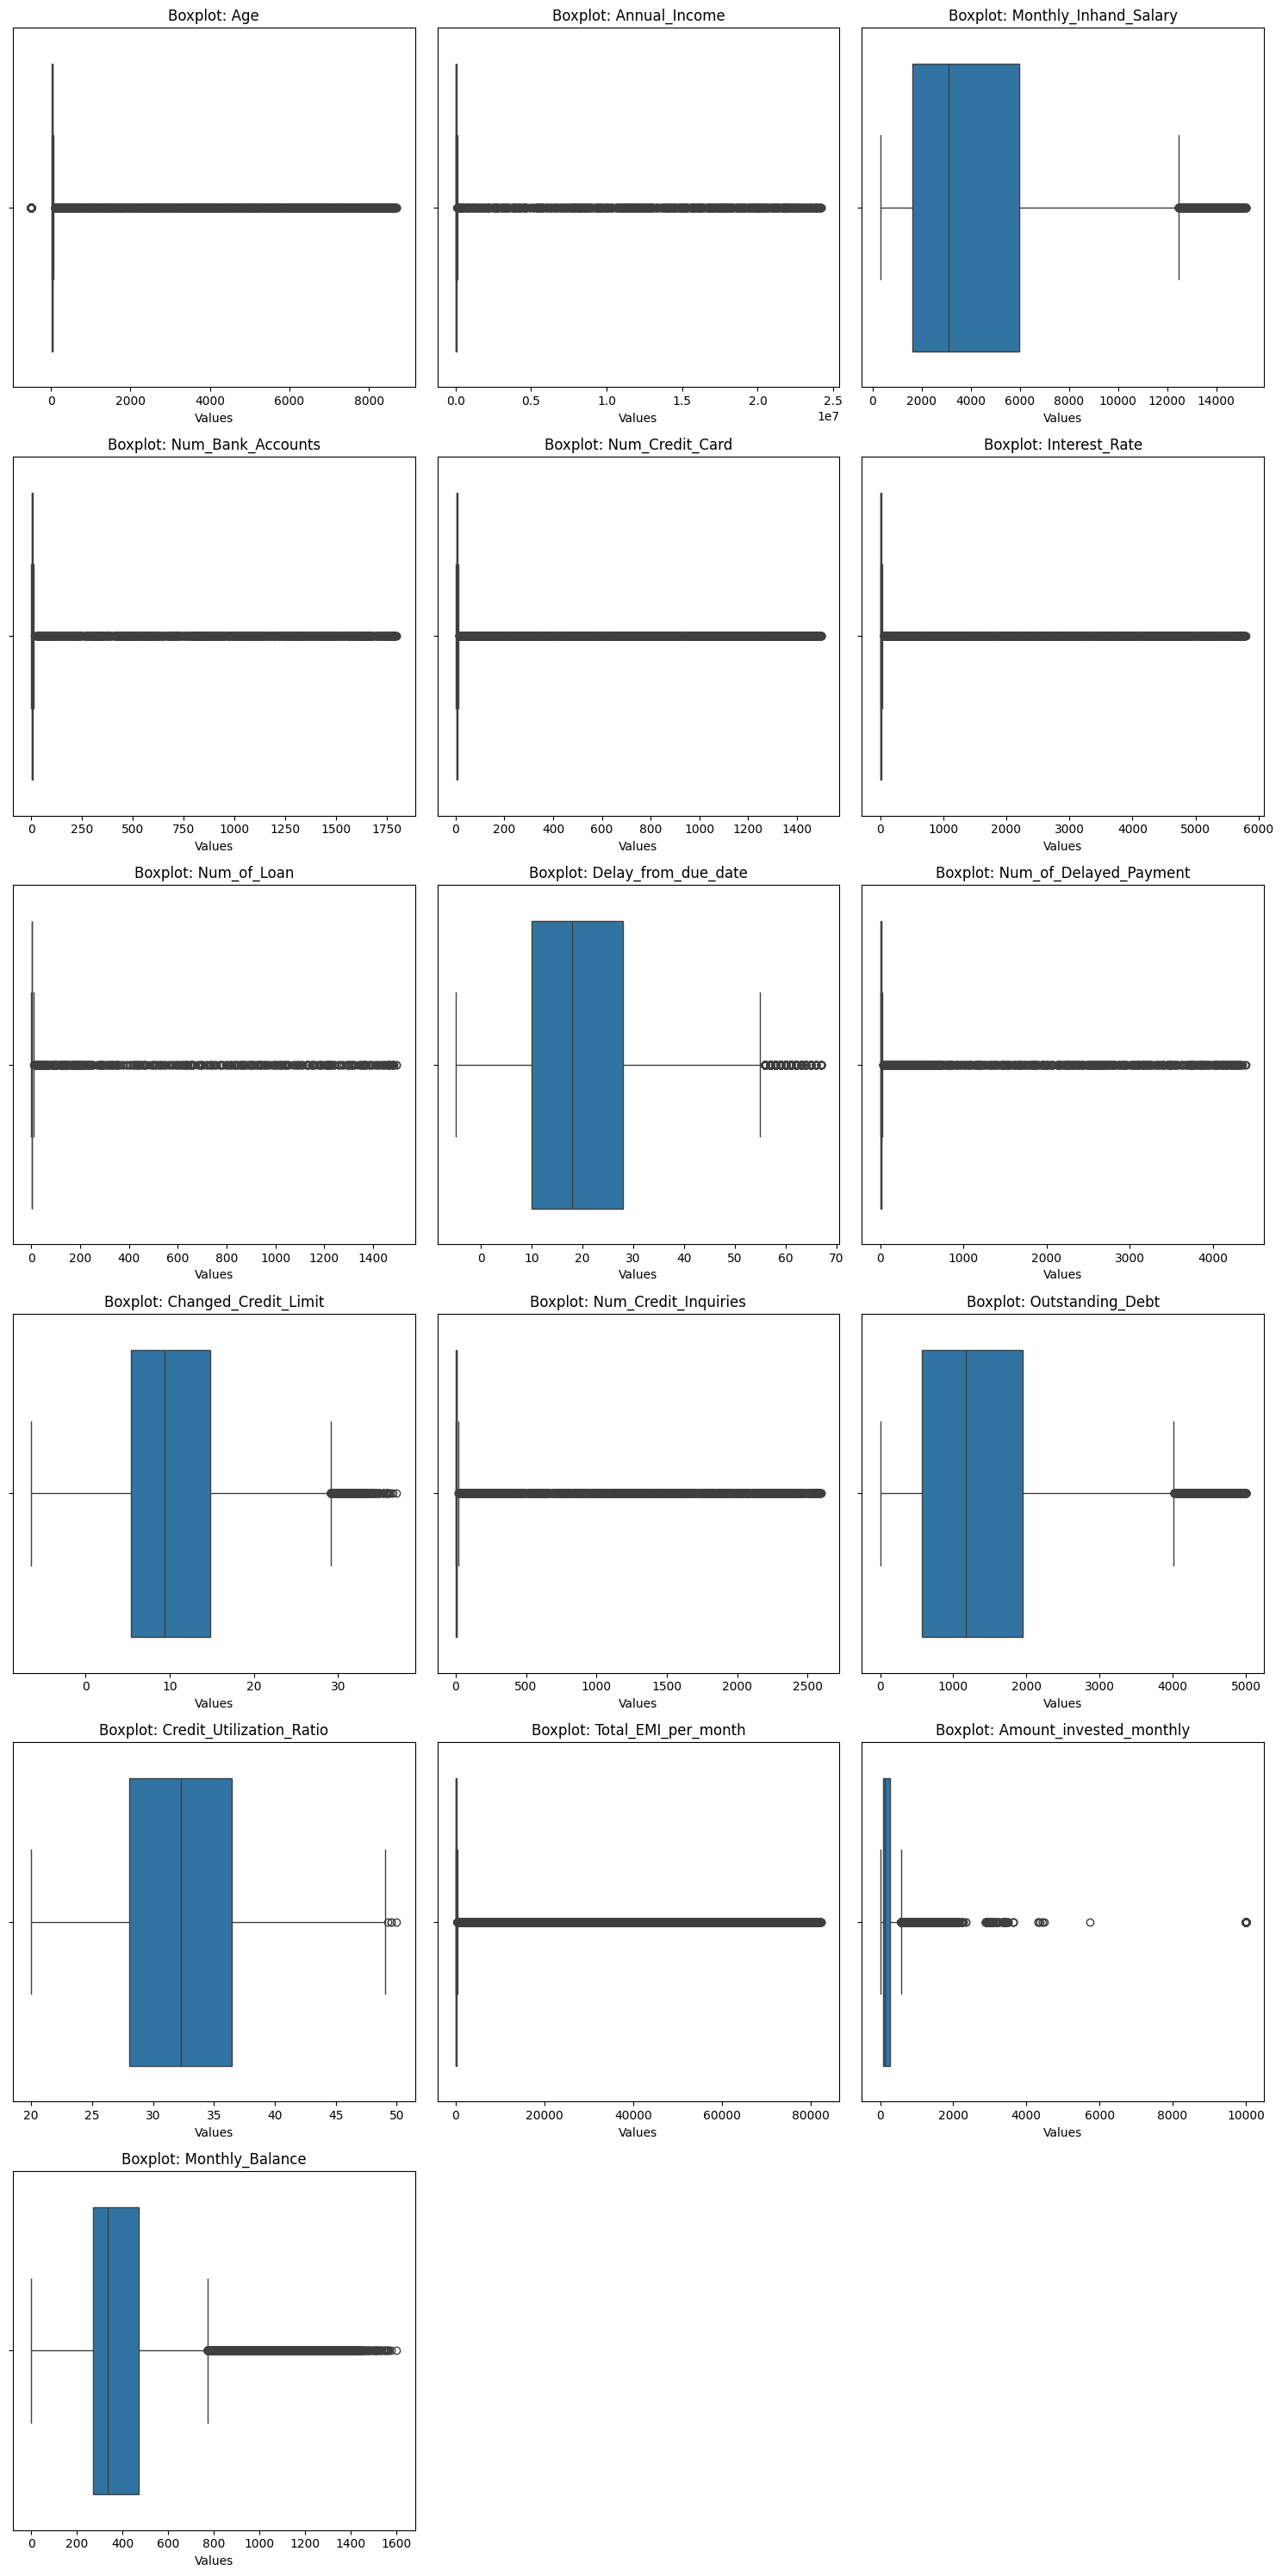

In [ ]:
visualize_outlier_columns(df, method='iqr')

## After preprocessing

In [ ]:
cleaned_df = pd.read_csv('/content/preprocessed_data (2).csv')
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28432 entries, 0 to 28431
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer_ID               28432 non-null  object 
 1   Age                       28432 non-null  float64
 2   Occupation                28432 non-null  int64  
 3   Annual_Income             28432 non-null  float64
 4   Monthly_Inhand_Salary     28432 non-null  float64
 5   Num_Bank_Accounts         28432 non-null  float64
 6   Num_Credit_Card           28432 non-null  int64  
 7   Interest_Rate             28432 non-null  int64  
 8   Num_of_Loan               28432 non-null  float64
 9   Delay_from_due_date       28432 non-null  int64  
 10  Num_of_Delayed_Payment    28432 non-null  float64
 11  Changed_Credit_Limit      28432 non-null  float64
 12  Num_Credit_Inquiries      28432 non-null  float64
 13  Outstanding_Debt          28432 non-null  float64
 14  Credit

<ipython-input-188-03db1ca067a4>:1: DtypeWarning: Columns (27,28,29,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  cleaned_df = pd.read_csv('/content/preprocessed_data (2).csv')


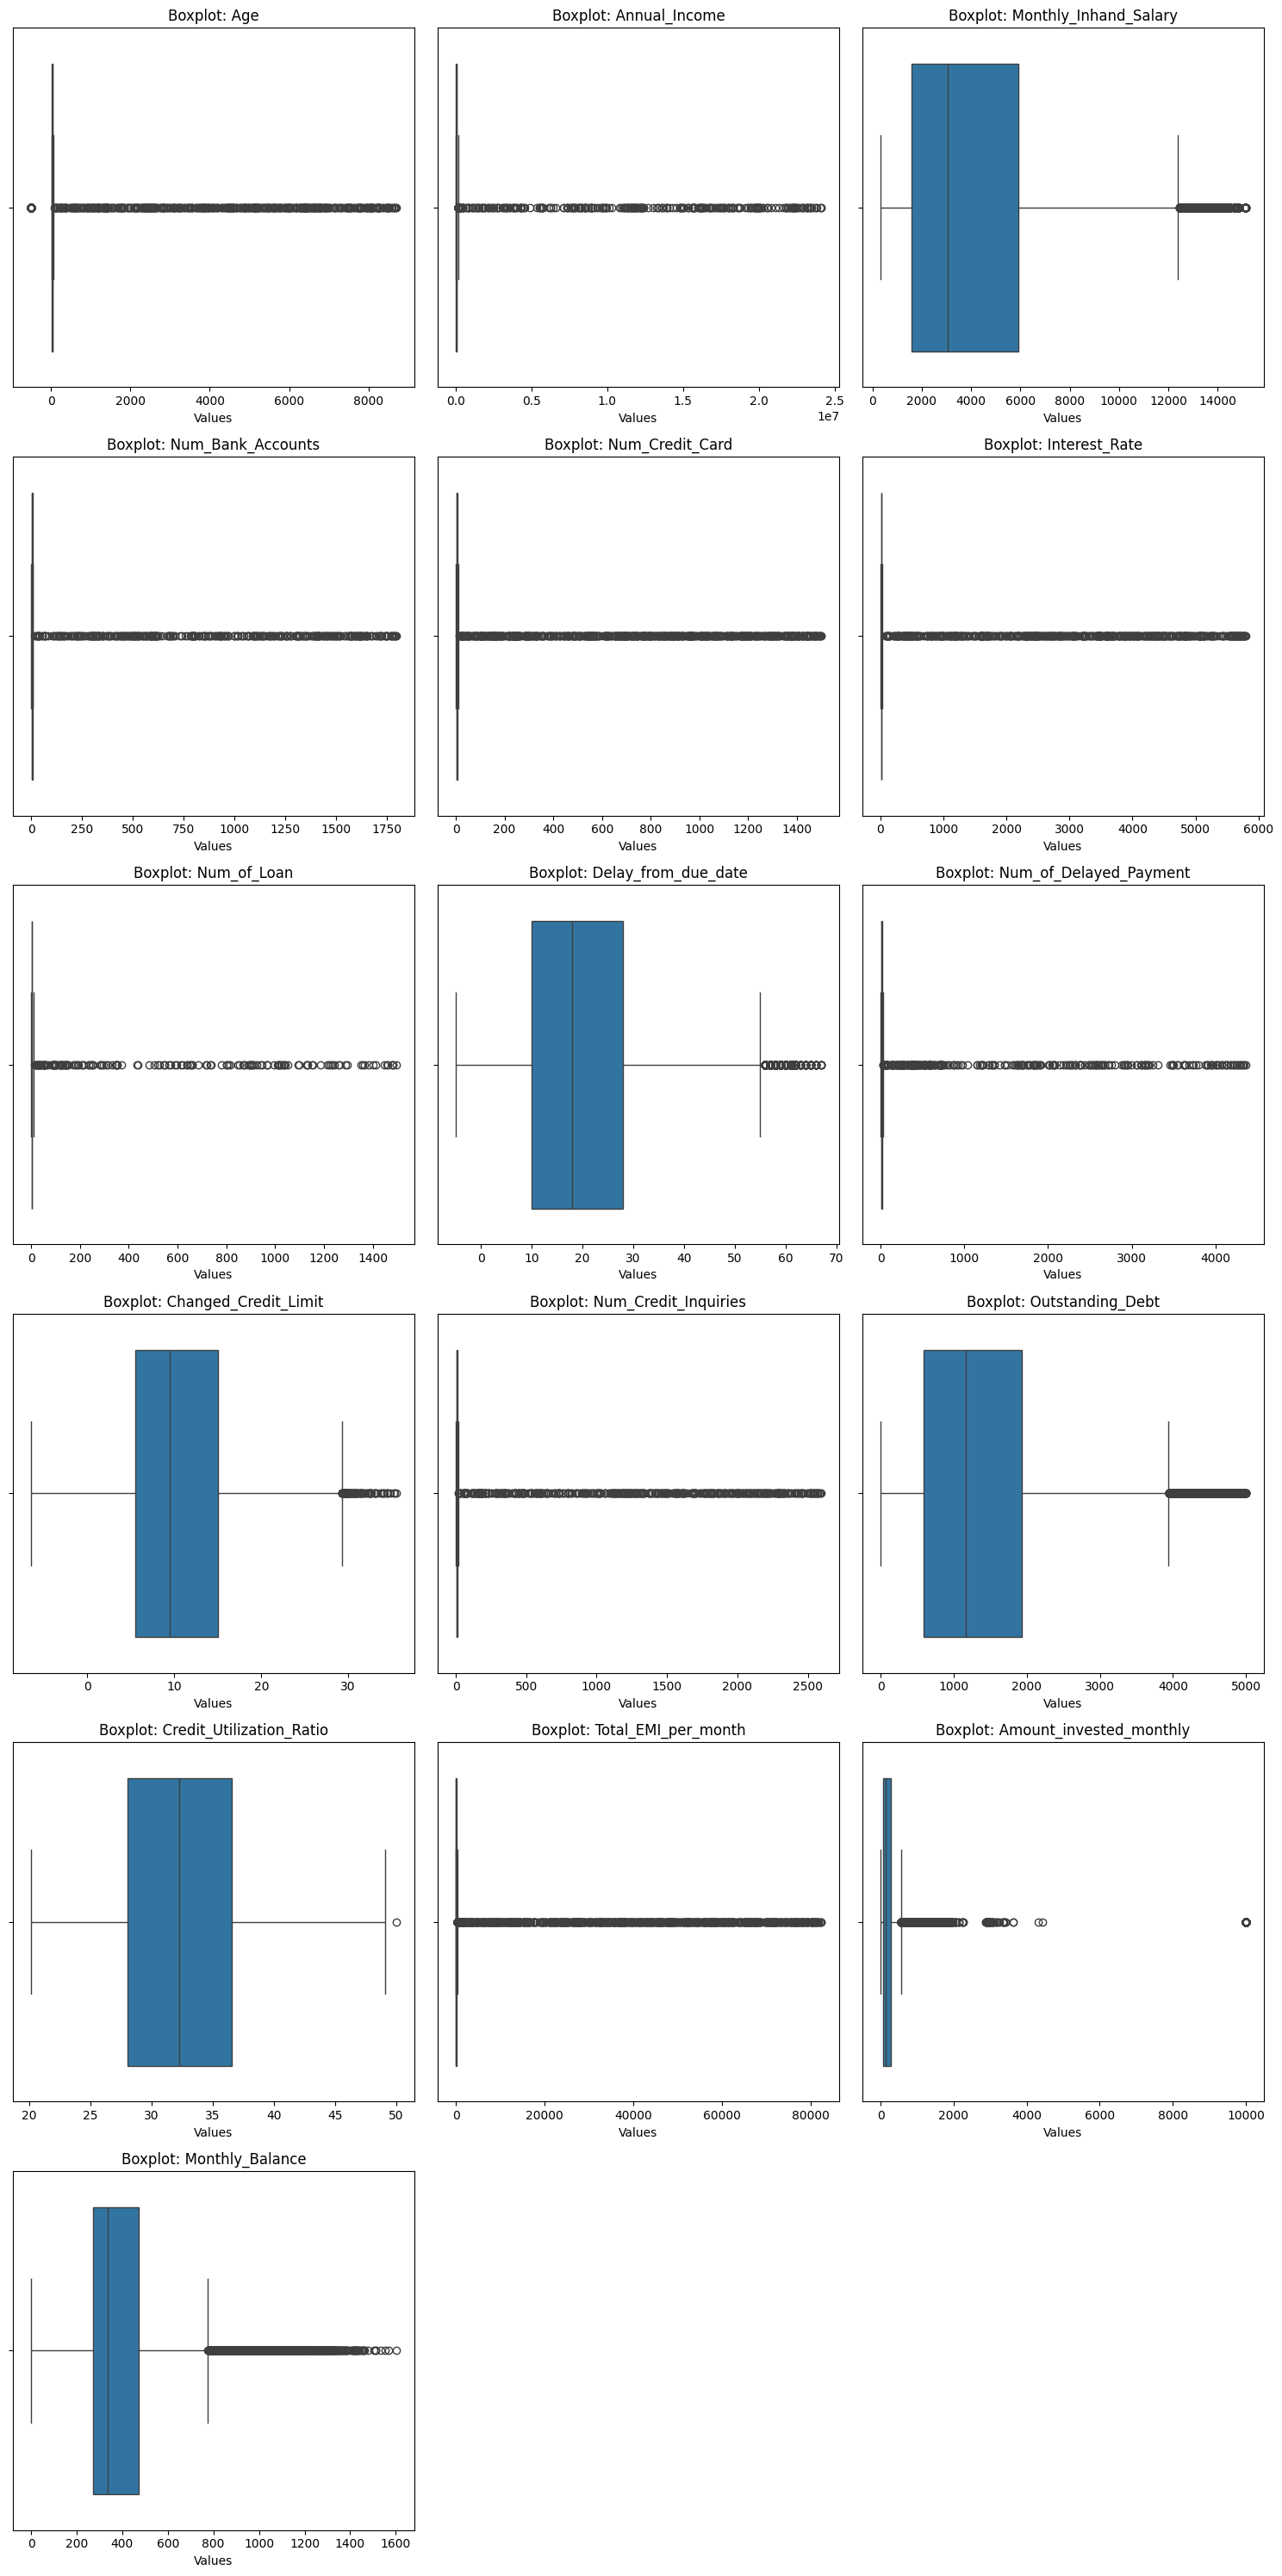

In [ ]:
visualize_outlier_columns(cleaned_df, method='iqr')